In [1]:
import pandas as pd
import os
import csv
import glob

def clean_decimal_commas(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(',', '.', regex=False)
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                pass
    return df

folder_path = "donnee_accident"
all_data = []
total_lines = 0

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".csv") and "caracteristiques" in filename:
            file_path = os.path.join(root, filename)
            year = None
            for y in ["2005", "2008", "2011", "2014", "2017", "2020", "2023"]:
                if y in filename:
                    year = y
                    break
            
            # Fonction pour essayer de lire avec utf-8 puis latin1
            def try_read_csv(path, **kwargs):
                try:
                    return pd.read_csv(path, encoding='utf-8', **kwargs)
                except UnicodeDecodeError:
                    return pd.read_csv(path, encoding='latin1', **kwargs)

            try:
                if year in ["2005", "2008", "2011", "2014", "2017"]:
                    df = try_read_csv(
                        file_path, 
                        sep=',', 
                        low_memory=False, 
                        on_bad_lines='skip', 
                        quoting=csv.QUOTE_NONE
                    )
                elif year in ["2020", "2023"]:
                    df = try_read_csv(
                        file_path, 
                        sep=';', 
                        low_memory=False, 
                        on_bad_lines='skip'
                    )
                else:
                    df = try_read_csv(
                        file_path, 
                        sep=';', 
                        low_memory=False, 
                        on_bad_lines='skip'
                    )
                
                df = clean_decimal_commas(df)
                all_data.append(df)
                total_lines += len(df)
                print(f"Chargé avec succès : {file_path} ({len(df)} lignes, {len(df.columns)} colonnes)")
            
            except Exception as e:
                print(f"Erreur avec {file_path} : {e}")

df_geo = pd.concat(all_data, ignore_index=True)
print(f"Total lignes concaténées : {len(df_geo)}")

Chargé avec succès : donnee_accident\Donnee_2005\caracteristiques_2005.csv (59073 lignes, 16 colonnes)
Chargé avec succès : donnee_accident\Donnee_2008\caracteristiques_2008.csv (44212 lignes, 16 colonnes)
Chargé avec succès : donnee_accident\Donnee_2011\caracteristiques_2011.csv (42675 lignes, 16 colonnes)
Chargé avec succès : donnee_accident\Donnee_2014\caracteristiques_2014.csv (36834 lignes, 16 colonnes)
Chargé avec succès : donnee_accident\Donnee_2017\caracteristiques_2017.csv (39994 lignes, 16 colonnes)
Chargé avec succès : donnee_accident\Donnee_2020\caracteristiques_2020.csv (47744 lignes, 15 colonnes)
Chargé avec succès : donnee_accident\Donnee_2023\caracteristiques_2023.csv (54822 lignes, 15 colonnes)
Total lignes concaténées : 325354


In [2]:
# Fonction pour détecter le séparateur
def detect_sep(filepath):
    with open(filepath, 'r', encoding='latin1') as file:
        sample = file.readline()
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample)
        return dialect.delimiter

# Charger tous les fichiers lieux
fichiers_lieux = glob.glob("donnee_accident/**/lieux_*.csv", recursive=True)

liste_lieux = []
for f in fichiers_lieux:
    try:
        sep = detect_sep(f)
        df = pd.read_csv(f, sep=sep, encoding='latin1', low_memory=False)
        liste_lieux.append(df)
    except Exception as e:
        print(f"Erreur avec {f} : {e}")

df_lieux = pd.concat(liste_lieux, ignore_index=True)

print(f"{len(df_lieux)} lignes chargées pour les fichiers lieux.")

469926 lignes chargées pour les fichiers lieux.


In [3]:
# Nettoyage des coordonnées GPS
df_geo = df_geo.dropna(subset=['lat', 'long'])

# Conversion en float (au cas où ce n’est pas encore fait)
df_geo['lat'] = df_geo['lat'].astype(float)
df_geo['long'] = df_geo['long'].astype(float)

# Corriger les valeurs comme 5051500 en 50.51500
df_geo['lat'] = df_geo['lat'].apply(lambda x: x / 100000 if abs(x) > 90 else x)
df_geo['long'] = df_geo['long'].apply(lambda x: x / 100000 if abs(x) > 180 else x)

# Filtrer les points géographiques uniquement en France métropolitaine
df_geo = df_geo[
    (df_geo['lat'].between(41.0, 51.5)) &
    (df_geo['long'].between(-5.0, 9.5))
]

print(f"Lignes après nettoyage et filtrage France : {len(df_geo)}")

Lignes après nettoyage et filtrage France : 186210


In [4]:
df_merged = pd.merge(df_geo, df_lieux[['Num_Acc', 'catr']], on='Num_Acc', how='left')
print(f"Après fusion : {len(df_merged)} lignes")

if "an" in df_merged:
    df_merged["an"] = df_merged["an"].apply(lambda x: x + 2000 if x < 100 else x)

Après fusion : 201619 lignes


C:\Users\pierr\AppData\Local\Temp\ipykernel_21536\2869940678.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=compte_routes.index, y=compte_routes.values, palette='viridis')


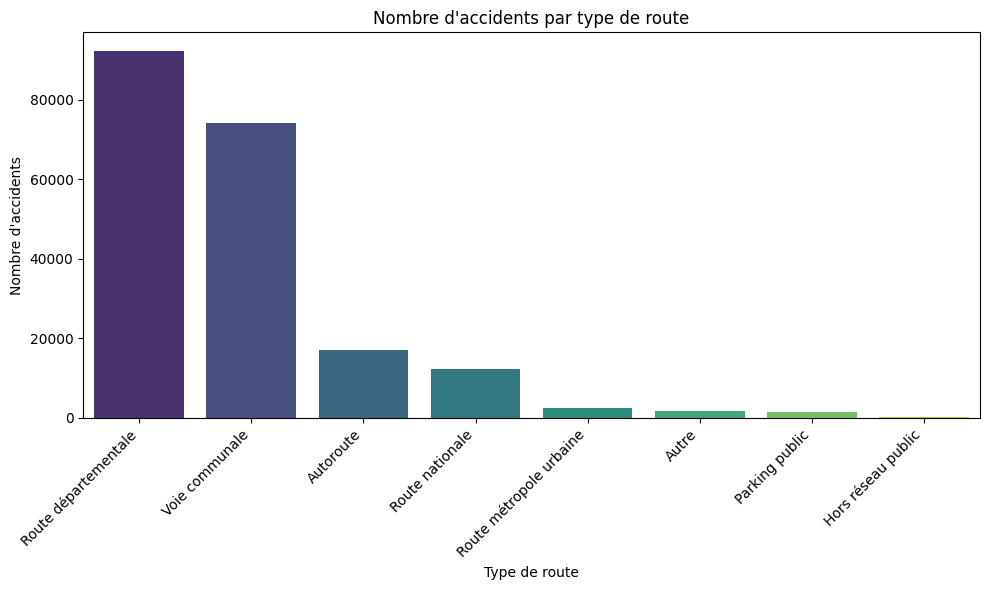

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

type_route = {
    1: "Autoroute",
    2: "Route nationale",
    3: "Route départementale",
    4: "Voie communale",
    5: "Hors réseau public",
    6: "Parking public",
    7: "Route métropole urbaine",
    9: "Autre"
}

# Remplacer les codes par les noms dans le DataFrame fusionné
df_merged['type_route_nom'] = df_merged['catr'].map(type_route).fillna('Inconnu')

# Compter le nombre d'accidents par type de route
compte_routes = df_merged['type_route_nom'].value_counts().sort_values(ascending=False)


# Affichage graphique
plt.figure(figsize=(10,6))
sns.barplot(x=compte_routes.index, y=compte_routes.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Nombre d'accidents par type de route")
plt.xlabel("Type de route")
plt.ylabel("Nombre d'accidents")
plt.tight_layout()
plt.show()

In [7]:
# Fonction principale
def creer_tableau_recapitulatif_avec_total(df):
    df_copy = df.copy()

    # Ajout colonne 'an'
    if 'an' not in df_copy.columns:
        if 'jour' in df_copy.columns:
            df_copy['an'] = pd.to_datetime(df_copy['jour'], errors='coerce').dt.year
        else:
            raise KeyError("Aucune colonne 'an' ou 'jour' trouvée.")

    # Ajout des noms de type de route
    if 'type_route_nom' not in df_copy.columns:
        df_copy['type_route_nom'] = df_copy['catr'].map(type_route).fillna('Inconnu')

    # Création du tableau
    tableau = (
        df_copy
        .groupby(['an', 'type_route_nom'])
        .size()
        .reset_index(name='nombre_accidents')
        .pivot(index='an', columns='type_route_nom', values='nombre_accidents')
        .fillna(0)
        .astype(int)
    )

    # Ajouter colonne et ligne Totals
    tableau['Total'] = tableau.sum(axis=1)
    tableau.loc['Total'] = tableau.sum()

    return tableau

# Création du tableau
tableau_recap = creer_tableau_recapitulatif_avec_total(df_merged)

# Sélection des sous-ensembles à colorer (sans 'Total')
colonnes_sans_total = tableau_recap.columns.difference(['Total'])
lignes_sans_total = tableau_recap.index.difference(['Total'])

# ✅ Appliquer le style uniquement sur la zone sans la ligne/colonne Total
styled_tableau = tableau_recap.style\
    .background_gradient(cmap='Oranges', subset=pd.IndexSlice[lignes_sans_total, colonnes_sans_total])\
    .format("{:,}")\
    .set_caption("📊 Nombre d'accidents par type de route et par année (avec total)")\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {
            'selector': 'caption',
            'props': [
                ('caption-side', 'top'),
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]
        }
    ])

styled_tableau

type_route_nom,Autoroute,Autre,Hors réseau public,Parking public,Route départementale,Route métropole urbaine,Route nationale,Voie communale,Total
an,,,,,,,,,
2005,461,319,15,39,"7,754",0,"2,114","1,240","11,942"
2008,432,221,16,46,"7,289",0,709,"1,318","10,031"
2011,"1,201",206,29,136,"9,188",0,"1,182","5,292","17,234"
2014,"1,562",155,34,144,"8,243",0,907,"4,669","15,714"
2017,"3,941",380,36,276,"16,181",0,"2,402","11,368","34,584"
2020,"4,324",287,64,324,"18,037",710,"2,198","19,156","45,100"
2023,"5,074",185,63,402,"25,660","1,852","2,721","31,057","67,014"
Total,"16,995","1,753",257,"1,367","92,352","2,562","12,233","74,100","201,619"


### 📋 Résumé de l’évolution des accidents par type de route (2005–2023)

- **Routes départementales** : Elles concentrent toujours le plus grand nombre d’accidents sur toute la période étudiée. Le nombre d’accidents a augmenté régulièrement, culminant à **16 181 accidents en 2017**, avant d'explser a  **25 660 en 2023**.

- **Voies communales** : Forte hausse notable entre 2008 (1 318) et 2017 (11 368), ce qui peut s’expliquer par une meilleure déclaration des accidents ou une évolution des infrastructures.

- **Autoroutes** : Montée progressive jusqu’en 2017 (3 941 accidents), avant une stagnation en 2023 (5 074 accidents). Cela pourrait être lié à des politiques de sécurité ou une baisse du trafic.

- **Routes nationales** : Une baisse significative de l’évolution des accidents, passant 2 114 en 2017 a 907 en 2014 puis une nouvelle hausse qui remonte a 2 721 en 2023.

- **Autres types de routes (hors réseau public, parkings, autres)** : Représentent une faible part du total des accidents, avec des chiffres globalement stables ou en baisse sur la période.

- **Année 2005 a 2017** : On remarque une augmentation de 189,56% des accidents, ce qui est lié à une évolution dans la manière dont les données sont collectées ou aux effets prolongés des politiques de prévention.

- **Année 2017 a 2023** : On remmarque un augmentation de 93,78% des accident, ce qui est deux moins que de 2005 a 2017 mais sur une perriode deux fois plus courte

> 📉 **Conclusion** : Bien que certaines routes comme les départementales et les autoroute restent les plus accidentogènes, les tendances générales montrent une augmentation globale des accidents en 2023, qu’il faudra analyser à la lumière des politiques de sécurité, de la mobilité, ou encore de la qualité des données collectées.


In [18]:
def detect_sep(filepath):
    with open(filepath, 'r', encoding='latin1') as file:
        sample = file.readline()
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample)
        return dialect.delimiter

# Charger tous les fichiers lieux
fichiers_lieux = glob.glob("donnee_accident/**/usagers_*.csv", recursive=True)

liste_lieux = []
for f in fichiers_lieux:
    try:
        sep = detect_sep(f)
        df = pd.read_csv(f, sep=sep, encoding='latin1', low_memory=False)
        liste_lieux.append(df)
    except Exception as e:
        print(f"Erreur avec {f} : {e}")

df_lieux = pd.concat(liste_lieux, ignore_index=True)

print(f"{len(df_lieux)} lignes chargées pour les fichiers Usagers.")

1016292 lignes chargées pour les fichiers Usagers.


Répartition en nombre :
grav_label  Blessé hospitalisé  Blessé léger  Indemne    Tué
sexe_label                                                  
Féminin                  62747        144795   118065   6374
Masculin                137400        226933   296487  21058

Répartition en pourcentage (par sexe) :
grav_label  Blessé hospitalisé  Blessé léger  Indemne   Tué
sexe_label                                                 
Féminin                  18.90         43.62    35.56  1.92
Masculin                 20.15         33.28    43.48  3.09


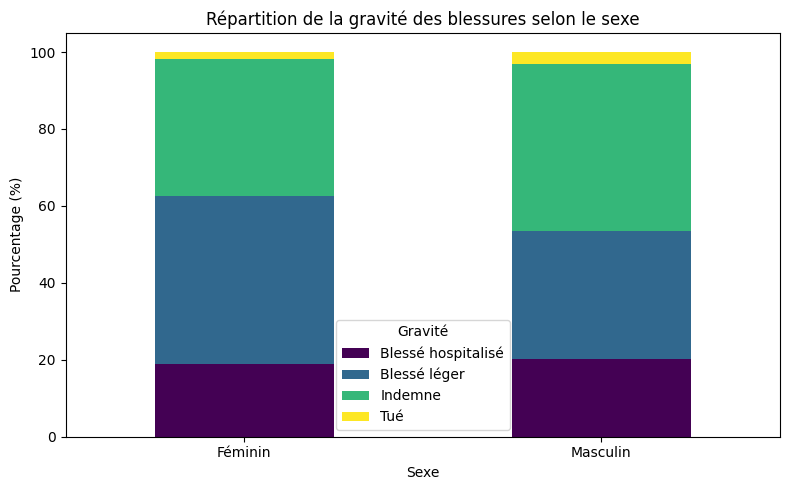

In [ ]:
# Dictionnaires pour remplacer les codes par des labels lisibles
grav_dict = {
    1: "Indemne",
    2: "Tué",
    3: "Blessé hospitalisé",
    4: "Blessé léger"
}

sexe_dict = {
    1: "Masculin",
    2: "Féminin"
}

# Remplacement des codes par des labels
df_lieux['grav_label'] = df_lieux['grav'].map(grav_dict)
df_lieux['sexe_label'] = df_lieux['sexe'].map(sexe_dict)

# Tableau croisé : nombre d'usagers par gravité et sexe
tableau = pd.crosstab(df_lieux['sexe_label'], df_lieux['grav_label'])

# Pourcentage par sexe (ligne)
tableau_pct = tableau.div(tableau.sum(axis=1), axis=0) * 100

print("Répartition en nombre :")
print(tableau)
print("\nRépartition en pourcentage (par sexe) :")
print(tableau_pct.round(2))

# Visualisation graphique
plt.figure(figsize=(8,5))
tableau_pct.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title("Répartition de la gravité des blessures selon le sexe")
plt.xlabel("Sexe")
plt.ylabel("Pourcentage (%)")
plt.legend(title="Gravité")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 👥 Répartition des victimes selon le sexe et la gravité des accidents

#### 📊 En nombre absolu :
- **Hommes** : Ils sont les plus touchés par les accidents, représentant :
  - 137 400 blessés hospitalisés,
  - 226 933 blessés légers,
  - 296 487 indemnes,
  - et **21 058 tués**.

- **Femmes** : Elles sont moins nombreuses dans chaque catégorie, avec :
  - 62 747 blessés hospitalisés,
  - 144 795 blessés légers,
  - 118 065 indemnes,
  - et **6 374 tuées**.

#### 📈 En pourcentage (par sexe) :
- **Femmes** :
  - 43,62 % sont blessées légères,
  - 35,56 % indemnes,
  - 18,90 % blessées hospitalisées,
  - 1,92 % tuées.

- **Hommes** :
  - 43,48 % indemnes,
  - 33,28 % blessés légers,
  - 20,15 % blessés hospitalisés,
  - **3,09 % tués** (soit une mortalité plus élevée que chez les femmes).

> 📌 **Conclusion** : Les hommes sont surreprésentés dans les accidents graves, notamment en ce qui concerne les décès. Bien qu’ils soient plus souvent indemnes, leur part de tués reste significativement plus élevée que celle des femmes.


C:\Users\pierr\AppData\Local\Temp\ipykernel_21536\2835975542.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gravite_age = df_lieux.groupby(['tranche_age', 'grav']).size().unstack(fill_value=0)


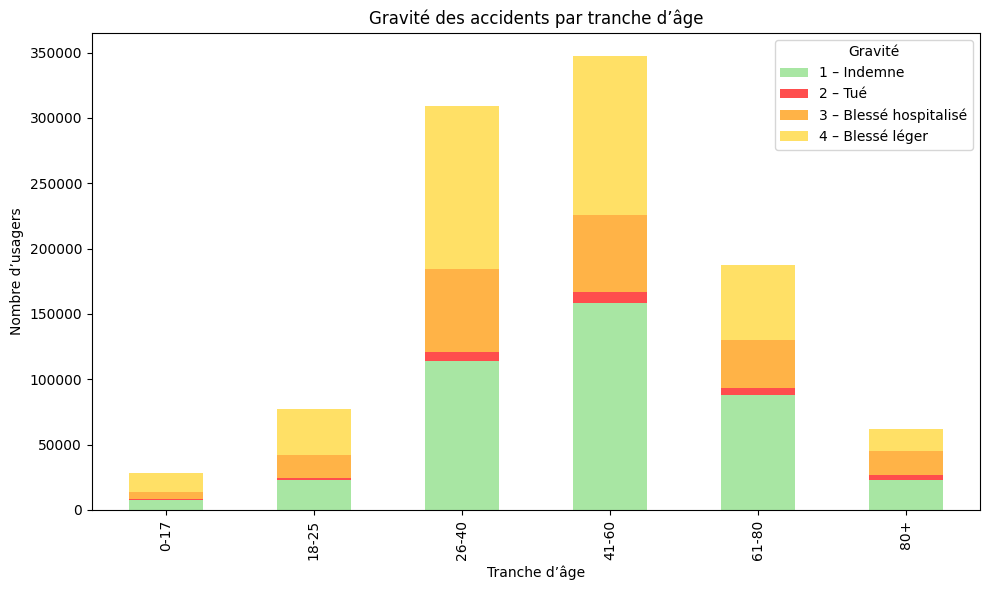

In [20]:

# Créer une colonne "âge"
df_lieux['age'] = 2023 - df_lieux['an_nais']

# Définir les tranches d’âge
tranches = [0, 17, 25, 40, 60, 80, 120]
noms_tranches = ['0-17', '18-25', '26-40', '41-60', '61-80', '80+']
df_lieux['tranche_age'] = pd.cut(df_lieux['age'], bins=tranches, labels=noms_tranches, right=True)

# Regrouper par tranche d’âge et gravité
gravite_age = df_lieux.groupby(['tranche_age', 'grav']).size().unstack(fill_value=0)

# Forcer l’ordre des colonnes de gravité
ordre_gravite = [1, 2, 3, 4]  # Indemne, Tué, Blessé hospitalisé, Blessé léger
gravite_age = gravite_age[ordre_gravite]

# Définir les couleurs personnalisées pour chaque gravité
couleurs = {
    1: '#a8e6a3',   # Vert clair – indemne
    2: '#ff4d4d',   # Rouge – tué
    3: '#ffb347',   # Orange – blessé hospitalisé
    4: '#ffe066'    # Jaune – blessé léger
}

# Tracer le graphique
gravite_age.plot(kind='bar', stacked=True,
                 color=[couleurs[g] for g in ordre_gravite],
                 figsize=(10, 6))

plt.title("Gravité des accidents par tranche d’âge")
plt.xlabel("Tranche d’âge")
plt.ylabel("Nombre d’usagers")
plt.legend(title='Gravité', labels=[
    '1 – Indemne',
    '2 – Tué',
    '3 – Blessé hospitalisé',
    '4 – Blessé léger'
])
plt.tight_layout()
plt.show()

In [21]:
# Copie du DataFrame avec des noms de colonnes explicites
gravite_age_tableau = gravite_age.rename(columns={
    1: "Indemne",
    2: "Tué",
    3: "Blessé hospitalisé",
    4: "Blessé léger"
})

# Ajouter une colonne "Total"
gravite_age_tableau["Total"] = gravite_age_tableau.sum(axis=1)

# Ajouter une ligne "Total"
gravite_age_tableau.loc["Total"] = gravite_age_tableau.sum(axis=0)

# Affichage
print("📊 Tableau récapitulatif du nombre d’usagers par tranche d’âge et gravité :\n")
print(gravite_age_tableau)

📊 Tableau récapitulatif du nombre d’usagers par tranche d’âge et gravité :

grav         Indemne    Tué  Blessé hospitalisé  Blessé léger    Total
tranche_age                                                           
0-17            7961    452                5469         14666    28548
18-25          23273   1529               16879         35704    77385
26-40         113682   7519               63548        124199   308948
41-60         158646   7901               59496        121654   347697
61-80          87648   5688               36685         57677   187698
80+            22755   4316               17748         17490    62309
Total         413965  27405              199825        371390  1012585


In [22]:
# Copier pour ne pas modifier l'original
gravite_age_pct = gravite_age_tableau.drop(index="Total", errors='ignore').copy()

# Calculer les pourcentages par ligne
colonnes_gravite = ["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"]
gravite_age_pct[colonnes_gravite] = gravite_age_pct[colonnes_gravite].div(
    gravite_age_pct["Total"], axis=0
) * 100

# Arrondir pour plus de lisibilité
gravite_age_pct[colonnes_gravite] = gravite_age_pct[colonnes_gravite].round(2)

# Recalculer les totaux en pourcentage (optionnel)
gravite_age_pct["Total"] = 100.0

# Ajouter une ligne "Total" si elle existait dans le tableau original
if "Total" in gravite_age_tableau.index:
    gravite_age_pct.loc["Total"] = gravite_age_tableau.loc["Total"]

# Affichage
print("📊 Tableau en pourcentage par tranche d’âge et gravité :\n")
print(gravite_age_pct)

📊 Tableau en pourcentage par tranche d’âge et gravité :

grav           Indemne       Tué  Blessé hospitalisé  Blessé léger      Total
tranche_age                                                                  
0-17             27.89      1.58               19.16         51.37      100.0
18-25            30.07      1.98               21.81         46.14      100.0
26-40            36.80      2.43               20.57         40.20      100.0
41-60            45.63      2.27               17.11         34.99      100.0
61-80            46.70      3.03               19.54         30.73      100.0
80+              36.52      6.93               28.48         28.07      100.0
Total        413965.00  27405.00           199825.00     371390.00  1012585.0


### 🧓 Analyse détaillée de la répartition des victimes selon l'âge et la gravité des accidents

L’analyse des accidents de la route en fonction de la tranche d’âge met en évidence des tendances marquantes sur la gravité des conséquences subies par les victimes.

#### 👶 0–17 ans :
Chez les plus jeunes, les accidents entraînent dans plus de la moitié des cas (51,37 %) des blessures légères. Un peu plus d’un quart (27,89 %) des jeunes ressortent indemnes, tandis que près de 19,16 % sont hospitalisés à la suite de leurs blessures. Le taux de mortalité reste relativement faible dans cette tranche d’âge (1,58 %).

#### 🧑‍🎓 18–25 ans :
Les jeunes adultes présentent un profil similaire à celui des mineurs. Les blessures légères représentent 46,14 % des cas, suivies par les indemnes (30,07 %) et les blessés hospitalisés (21,81 %). La mortalité augmente légèrement (1,98 %) mais reste encore relativement basse.

#### 👨‍👩‍👧 26–40 ans :
Dans cette tranche d’âge, on note une amélioration de la proportion de personnes indemnes (36,80 %). Les blessés légers représentent encore 40,20 %, mais les hospitalisations (20,57 %) et la mortalité (2,43 %) sont en légère hausse. Cela peut être lié à une plus grande exposition au risque (fréquentation élevée de la route).

#### 🧔 41–60 ans :
Les individus de cette tranche ressortent indemnes dans près de la moitié des cas (45,63 %), ce qui représente l’un des meilleurs taux. La proportion de blessés légers baisse à 34,99 %, et celle des hospitalisés à 17,11 %. Le taux de mortalité reste stable à 2,27 %.

#### 👵 61–80 ans :
Les seniors ont le taux d’indemnes le plus élevé (46,70 %), mais les hospitalisations (19,54 %) et la mortalité (3,03 %) commencent à augmenter. Le corps étant plus fragile, les accidents ont souvent des conséquences plus graves.

#### 🧓 80 ans et plus :
Cette tranche d’âge est la plus vulnérable. Le taux de mortalité est le plus élevé (6,93 %), près de trois fois supérieur à celui des adultes plus jeunes. Les blessures graves sont également plus fréquentes, avec 28,48 % de blessés hospitalisés. Les blessés légers (28,07 %) et les indemnes (36,52 %) sont moins représentés.

---

#### 🔢 Données globales (toutes tranches d’âge confondues) :
- **Indemnes** : 413 965
- **Tués** : 27 405
- **Blessés hospitalisés** : 199 825
- **Blessés légers** : 371 390
- **Total** : 1 012 585 victimes recensées

---

### 📌 Conclusion :

L’analyse montre une évolution de la gravité des accidents en fonction de l’âge :
- **Les plus jeunes (0–25 ans)** sont majoritairement blessés légèrement.
- **Les adultes d’âge moyen (26–60 ans)** ont plus de chances de sortir indemnes d’un accident.
- **Les personnes âgées (61 ans et plus)** présentent des taux plus élevés de blessures graves et de mortalité, avec un pic inquiétant chez les **80 ans et plus**, qui sont les plus à risque de mourir ou d’être hospitalisés après un accident.

Cela souligne la nécessité d’une vigilance particulière pour les conducteurs et passagers âgés, et peut aussi alimenter des réflexions sur des politiques de prévention ciblées selon l’âge.


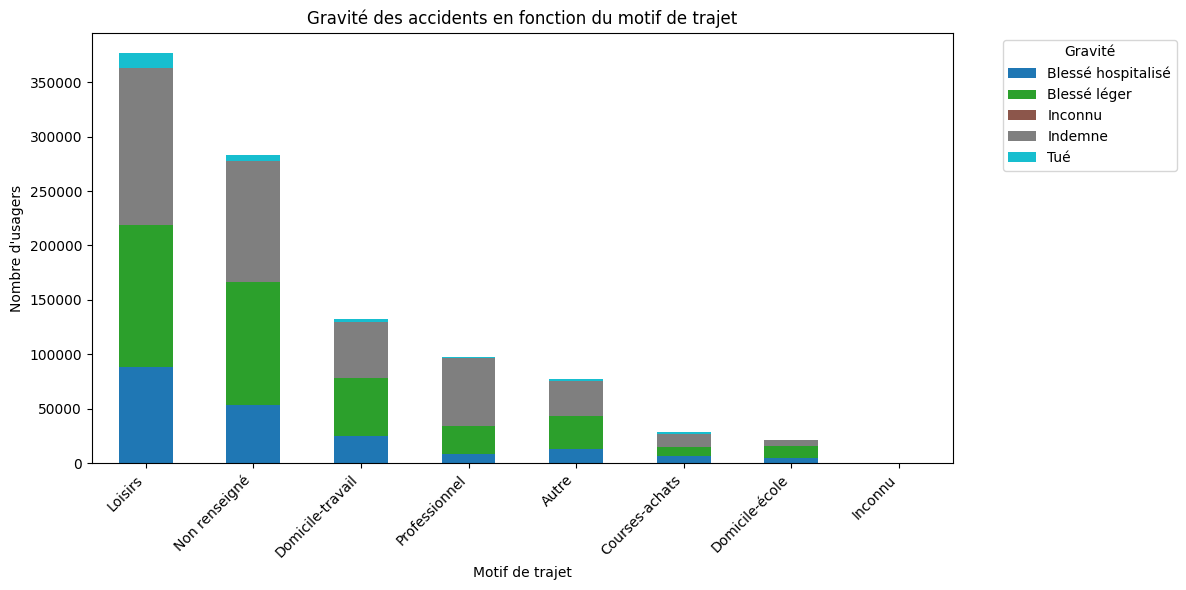

In [23]:
trajet_labels = {
    -1: "Non renseigné",
    0: "Non renseigné",
    1: "Domicile-travail",
    2: "Domicile-école",
    3: "Courses-achats",
    4: "Professionnel",
    5: "Loisirs",
    9: "Autre"
}

grav_labels = {
    1: "Indemne",
    2: "Tué",
    3: "Blessé hospitalisé",
    4: "Blessé léger"
}

# Appliquer les labels
df_lieux['trajet_label'] = df_lieux['trajet'].map(trajet_labels).fillna('Inconnu')
df_lieux['grav_label'] = df_lieux['grav'].map(grav_labels).fillna('Inconnu')

# Tableau croisé (pivot)
grav_trajet = pd.crosstab(df_lieux['trajet_label'], df_lieux['grav_label'])

# Tri optionnel par total décroissant
grav_trajet = grav_trajet.loc[grav_trajet.sum(axis=1).sort_values(ascending=False).index]

# Tracer le graphique
grav_trajet.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title("Gravité des accidents en fonction du motif de trajet")
plt.xlabel("Motif de trajet")
plt.ylabel("Nombre d'usagers")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

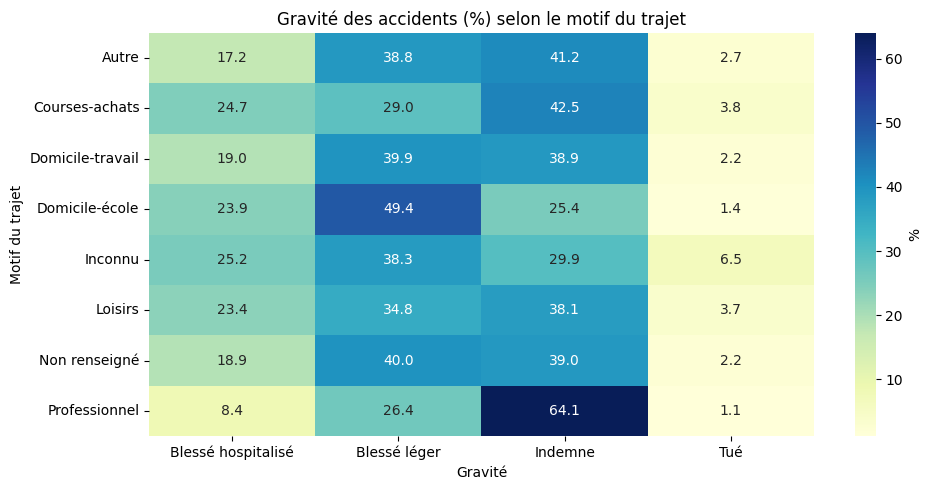

grav_label        Blessé hospitalisé  Blessé léger  Indemne   Tué
trajet_label                                                     
Autre                          17.22         38.83    41.21  2.74
Courses-achats                 24.69         29.00    42.47  3.84
Domicile-travail               18.99         39.90    38.90  2.21
Domicile-école                 23.90         49.37    25.37  1.36
Inconnu                        25.23         38.32    29.91  6.54
Loisirs                        23.39         34.81    38.12  3.67
Non renseigné                  18.85         40.04    38.95  2.16
Professionnel                   8.40         26.45    64.06  1.09


In [24]:
# Filtrer uniquement les gravités connues (1 à 4)
df_filtre = df_lieux[df_lieux['grav'].isin([1, 2, 3, 4])].copy()

# Appliquer les labels
df_filtre['trajet_label'] = df_filtre['trajet'].map(trajet_labels).fillna('Inconnu')
df_filtre['grav_label'] = df_filtre['grav'].map(grav_labels)

# Tableau croisé en effectif
tableau = pd.crosstab(df_filtre['trajet_label'], df_filtre['grav_label'])

# Convertir en pourcentage par ligne
tableau_pct = tableau.div(tableau.sum(axis=1), axis=0) * 100
tableau_pct = tableau_pct.round(2)

# Affichage graphique

plt.figure(figsize=(10, 5))
sns.heatmap(tableau_pct, annot=True, cmap="YlGnBu", fmt=".1f", cbar_kws={'label': '%'})
plt.title("Gravité des accidents (%) selon le motif du trajet")
plt.xlabel("Gravité")
plt.ylabel("Motif du trajet")
plt.tight_layout()
plt.show()

# Affichage dans la console
print(tableau_pct)

# Analyse détaillée des gravités des blessures selon le type de trajet

Les données fournies montrent une répartition des conséquences des accidents en fonction du type de trajet effectué par les victimes. On distingue quatre niveaux de gravité : blessé hospitalisé, blessé léger, indemne, et tué.

Pour les trajets classés comme **"Autre"**, on constate que près d’un accident sur six (17,22%) aboutit à une hospitalisation, tandis qu’une majorité des victimes (38,83%) souffre de blessures légères. Une part importante (41,21%) sort indemne de l’accident, ce qui suggère que malgré la diversité de ce type de trajets, un nombre non négligeable d’accidents est relativement peu grave. Cependant, 2,74% des cas sont mortels, ce qui reste significatif.

Les trajets liés aux **courses et achats** montrent une tendance différente avec une proportion plus élevée de blessés hospitalisés (24,69%), indiquant une gravité moyenne plus importante dans ces situations. Le pourcentage de blessés légers est un peu plus bas (29%), mais le nombre d’indemnes reste élevé (42,47%). La mortalité (3,84%) est également supérieure à celle observée pour d’autres catégories, ce qui peut refléter des situations plus à risque, possiblement liées à la circulation urbaine dense ou à des comportements plus précipités.

Concernant les trajets **domicile-travail**, la répartition des blessés hospitalisés (18,99%) et légers (39,90%) est relativement équilibrée. Le nombre de personnes indemnes (38,90%) est comparable à celui des blessés légers. La mortalité est modérée (2,21%). Ces chiffres montrent que ce type de trajet, souvent réalisé quotidiennement, comporte un risque de blessure notable, même si la majorité des accidents ne sont pas fatals.

Les trajets entre **domicile et école** présentent une particularité : une forte proportion de blessés légers (49,37%), la plus élevée de toutes les catégories, tandis que le pourcentage d’hospitalisations est relativement important (23,90%). Les indemnes sont ici moins nombreux (25,37%) et la mortalité la plus faible (1,36%). Cette répartition peut refléter la nature des déplacements scolaires, souvent courts et réalisés à vitesse réduite, limitant la gravité des accidents.

La catégorie **Inconnu**, correspondant aux trajets non identifiés, est celle qui enregistre la plus forte proportion de blessés hospitalisés (25,23%) et la mortalité la plus élevée (6,54%). Ces chiffres suggèrent que les accidents pour lesquels on ne connaît pas le type de trajet sont souvent plus graves, peut-être en raison d’une moindre maîtrise des circonstances ou d’un défaut d’enregistrement précis.

Les trajets liés aux **loisirs** montrent une proportion significative de blessés hospitalisés (23,39%) et de tués (3,67%), avec une majorité de blessés légers (34,81%) et indemnes (38,12%). Ces données peuvent s’expliquer par des comportements plus à risque lors des activités de loisir, comme la pratique sportive ou les sorties.

Pour les trajets **non renseignés**, la répartition est proche des moyennes générales, avec environ 19% d’hospitalisations, 40% de blessés légers et 39% indemnes. La mortalité reste relativement faible (2,16%), ce qui indique que cette catégorie regroupe probablement des situations diverses, moyennement représentatives.

Enfin, les trajets **professionnels** se distinguent nettement par une faible gravité des accidents : seuls 8,40% des victimes sont hospitalisées, et 26,45% présentent des blessures légères. La grande majorité (64,06%) sort indemne, et la mortalité est la plus basse (1,09%). Cela peut s’expliquer par des mesures de sécurité renforcées, une formation plus rigoureuse des conducteurs professionnels, ou une vigilance accrue lors de ces trajets.

---

En conclusion, ces données suggèrent que la gravité des blessures liées aux accidents varie fortement selon le type de trajet. Les trajets professionnels sont globalement les moins dangereux, tandis que les trajets inconnus et ceux liés aux courses ou loisirs présentent un risque accru de blessures graves et de mortalité. Les déplacements scolaires se caractérisent par une forte proportion de blessures légères, et les trajets domicile-travail affichent une répartition équilibrée entre blessés légers et indemnes. Ces informations peuvent guider des politiques ciblées de prévention routière en fonction des contextes de déplacement.
